# REDUCEDHEATCARB analysis

This JupyterLabs notebook can be used for physics ifnormed machine learning analysis in the REDUCEDHEATCAB project.
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!

## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [1]:
import numpy as np
import pandas as pd

%load_ext autoreload

    
from tqdm.notebook import tqdm

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

from plotter import Plot
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget


from nfh_utils import *

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

from rhc_analysis import Learner

# rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_5_min.parquet'
rhc_preprocessed_poperties_file='rhc_preprocessed_properties_intv_1_min.parquet'
#rhc_preprocessed_poperties_file='rhc_heat_dist_preprocessed_properties.parquet'

home_data_file_path = "home_data.parquet"
boiler_returntemp_load_efficiency_file_path = "boiler_returntemp_load_efficiency.parquet"
boiler_returntemp_efficiency_file_path = "boiler_returntemp_efficiency.parquet"




### Reading preprocessed interpolated properties from a parquet file

In [2]:
%%time

# Attempt to read the Parquet file
try:
    df_prep = pd.read_parquet(
        rhc_preprocessed_poperties_file, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

File was successfully read without specifying compression codec.
CPU times: user 6.35 s, sys: 4.86 s, total: 11.2 s
Wall time: 6.82 s


In [3]:
#sorting the DataFrame index is needed to get good performance on certain filters
#this guarding code to check whether DataFrames are properly sorted
if not df_prep.index.is_monotonic_increasing:
    print('df needed index sorting')
    df_prep = df_prep.sort_index()  

In [4]:
print(f"df_prep.count().sum(): {df_prep.count().sum():_}")

df_prep.count().sum(): 194_313_186


In [5]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9582620 entries, (401632, Timestamp('2023-04-01 00:00:00+0200', tz='Europe/Amsterdam')) to (495906, Timestamp('2024-04-04 01:00:00+0200', tz='Europe/Amsterdam'))
Data columns (total 78 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   batch_import_KNMI_ghi__W_m_2                             Float32
 1   batch_import_KNMI_temp_out__degC                         Float32
 2   batch_import_remeha_temp_out__degC                       Float32
 3   batch_import_KNMI_wind__m_s_1                            Float32
 4   batch_import_enelogic_e_ret_monthly_hi_cum__kWh          Float64
 5   batch_import_enelogic_e_ret_monthly_lo_cum__kWh          Float64
 6   batch_import_enelogic_e_use_monthly_hi_cum__kWh          Float64
 7   batch_import_enelogic_e_use_monthly_lo_cum__kWh          Float64
 8   batch_import_enelogic_g_use_monthly_cum__m3       

In [6]:
print("[\n'","', \n'".join(sorted(df_prep.columns)),"'\n]")

[
' batch_import_KNMI_ghi__W_m_2', 
'batch_import_KNMI_temp_out__degC', 
'batch_import_KNMI_wind__m_s_1', 
'batch_import_enelogic_e_ret_monthly_hi__W', 
'batch_import_enelogic_e_ret_monthly_hi_cum__kWh', 
'batch_import_enelogic_e_ret_monthly_lo__W', 
'batch_import_enelogic_e_ret_monthly_lo_cum__kWh', 
'batch_import_enelogic_e_use_monthly_hi__W', 
'batch_import_enelogic_e_use_monthly_hi_cum__kWh', 
'batch_import_enelogic_e_use_monthly_lo__W', 
'batch_import_enelogic_e_use_monthly_lo_cum__kWh', 
'batch_import_enelogic_g_use_monthly_cum__m3', 
'batch_import_enelogic_g_use_monthly_hhv__W', 
'batch_import_remeha_boiler_status_blocking_mode__bool', 
'batch_import_remeha_boiler_status_burner_start__bool', 
'batch_import_remeha_boiler_status_burner_stop__bool', 
'batch_import_remeha_boiler_status_burning_ch__bool', 
'batch_import_remeha_boiler_status_burning_dhw__bool', 
'batch_import_remeha_boiler_status_controlled_stop__bool', 
'batch_import_remeha_boiler_status_de_air__bool', 
'batch_import

In [7]:
%autoreload 2
units_to_mathtext = property_types = {
    'degC' : r'$°C$',
    'ppm' : r'$ppm$',
    '0' : r'$[-]$',
    'bool': r'$0 = False; 1 = True$',
    'p' : r'$persons$',
    'W' : r'$W$',
    'W_m_2' : r'$W/m^{2}$',
    'm_s_1' : r'$m/s$'    
}

In [8]:
# visuaize all input data
df_plot = df_prep

In [9]:
list(df_plot.index.unique('id').dropna())

[401632,
 403603,
 404873,
 410260,
 412715,
 424197,
 429011,
 430062,
 434931,
 444964,
 449134,
 450298,
 456638,
 458000,
 458852,
 478667,
 483173,
 487126,
 494233,
 495906]

In [10]:
df_plot.index.unique('id').dropna()

Index([401632, 403603, 404873, 410260, 412715, 424197, 429011, 430062, 434931,
       444964, 449134, 450298, 456638, 458000, 458852, 478667, 483173, 487126,
       494233, 495906],
      dtype='Int64', name='id')

In [11]:
# df_plot.loc[[401632]][[prop for prop in df_plot.columns.values if prop.split('__')[-1] in ('degC', 'W', '0', 'bool', 'ppm', 'W_m_2')]]

In [12]:
#Plot all properties from all sources for all ids
#Plot.dataframe_preprocessed_plot(df_plot.loc[[401632]][[prop for prop in df_plot.columns.values if prop.split('__')[-1] in ('degC', 'ppm', 'W_m_2')]], units_to_mathtext)

# Calculate additional properties 
We may have to move some of these calculations to inside the GEKKO Python model code (e.g. for the what-if scenario simulation)

### Calculating electricity data

In [13]:
%%time
df_prep['calculated_device_p1-reader_e_use__W'] = df_prep['device_p1-reader_e_use_hi__W'] + df_prep['device_p1-reader_e_use_lo__W']
df_prep['calculated_device_p1-reader_e_ret__W'] = df_prep['device_p1-reader_e_ret_hi__W'] + df_prep['device_p1-reader_e_ret_lo__W'] 


CPU times: user 66.9 ms, sys: 95.6 ms, total: 163 ms
Wall time: 56.3 ms


### Reading and calculating boiler data 

#### Reading home metadata

In [14]:
%%time
# Attempt to read the Parquet file
try:
    df_homes = pd.read_parquet(
        home_data_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

File was successfully read without specifying compression codec.
CPU times: user 7.06 ms, sys: 2.48 ms, total: 9.54 ms
Wall time: 6.13 ms


In [15]:
df_homes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 401632 to 495906
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   weather_lat__degN                           20 non-null     Float64
 1   weather_lon__degE                           20 non-null     Float64
 2   weather_H3_cell_id                          20 non-null     string 
 3   brand_model                                 20 non-null     string 
 4   boiler_default_min_fan_rotations__min_1     20 non-null     Int64  
 5   min_fan_rotations__min_1                    20 non-null     Int64  
 6   boiler_default_max_ch_fan_rotations__min_1  20 non-null     Int64  
 7   max_ch_fan_rotations__min_1                 20 non-null     Int64  
 8   table_eta_ch_hhv__W0                        20 non-null     string 
 9   100%_load_ch_rotations_min_1                20 non-null     Int64  
 10  100%_load_ch

In [16]:
df_homes


,weather_lat__degN,weather_lon__degE,weather_H3_cell_id,brand_model,boiler_default_min_fan_rotations__min_1,min_fan_rotations__min_1,boiler_default_max_ch_fan_rotations__min_1,max_ch_fan_rotations__min_1,table_eta_ch_hhv__W0,100%_load_ch_rotations_min_1,100%_load_ch__g25_3_ref_lhv__kW,rotation__m3,power_ch_min__kW,power_ch_max__kW
id,,,,,,,,,,,,,,
401632,51.8,5.57,8419693ffffffff,Remeha Calenta Ace 40L,1950,1400,4400,7000,calenta_ace_40l_Hs.csv,7000,34.8,0.0,4.5,40.3
403603,51.31,3.56,84194d9ffffffff,Remeha Tzerra Ace 39c,2070,1200,5900,7400,tzerra_ace_39c_Hs.csv,7400,34.9,0.0,2.7,38.5
404873,52.13,5.39,8419691ffffffff,Remeha Tzerra Ace 28c,1870,1200,4700,7400,tzerra_ace_28c_Hs.csv,7400,24.0,0.0,2.1,33.4
410260,52.13,5.39,8419691ffffffff,Remeha Tzerra Ace 39c,2070,1200,5900,7400,tzerra_ace_39c_Hs.csv,7400,34.9,0.0,2.7,38.5
412715,51.11,5.94,841fa55ffffffff,Remeha Tzerra Ace 28c,1870,1200,4700,7400,tzerra_ace_28c_Hs.csv,7400,24.0,0.0,2.1,33.4
424197,52.39,6.42,841f16dffffffff,Remeha Tzerra Ace 28c,1870,1200,4700,7400,tzerra_ace_28c_Hs.csv,7400,24.0,0.0,2.1,33.4
429011,53.06,6.06,84196d1ffffffff,Remeha Avanta Ace 35c,3200,2500,7000,10300,avanta_ace_35c_Hs.csv,10300,30.9,0.0,4.4,36.0
430062,52.09,6.0,841969bffffffff,Remeha Calenta Ace 28c,1900,1400,4600,7000,calenta_ace_28c_Hs.csv,7000,25.0,0.0,2.6,32.3
434931,52.8,5.01,841968bffffffff,Remeha Calenta Ace 40L,1950,1400,4400,7000,calenta_ace_40l_Hs.csv,7000,34.8,0.0,4.5,40.3


#### Reading boiler data

In [17]:
%%time
# Attempt to read the Parquet file
try:
    df_boiler_efficiency = pd.read_parquet(
        # boiler_returntemp_efficiency_file_path, 
        boiler_returntemp_load_efficiency_file_path, 
        engine='pyarrow',
        dtype_backend='numpy_nullable'
        )
    print("File was successfully read without specifying compression codec.")
except Exception as e:
    print(f"Error reading file: {e}")

File was successfully read without specifying compression codec.
CPU times: user 16.8 ms, sys: 8.44 ms, total: 25.3 ms
Wall time: 16.2 ms


In [18]:
df_boiler_efficiency

eta_ch_hhv__W0
brand_model                 rounded_p_load__% rounded_temp_ret__degC                
Remeha Avanta Ace 28c       20.0              20.0                               1.0
                                              21.0                               1.0
                                              22.0                               1.0
                                              23.0                               1.0
                                              24.0                              0.99
...                                                                              ...
Remeha Tzerra Ace Matic 35c 100.0             66.0                              0.88
                                              67.0                              0.88
                                              68.0                              0.88
                                              69.0                              0.88
                                              70.0                              0.88

[33558 rows x 1 columns]

#### Prepare lookup of momentary boiler efficiency from boiler-specific efficiency curves

In [19]:
%%time
# Round return temperatures to whole degrees
df_prep['rounded_temp_ret__degC'] = df_prep['batch_import_remeha_temp_ret__degC'].round()

CPU times: user 7.9 ms, sys: 33.1 ms, total: 41 ms
Wall time: 27.1 ms


In [20]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9582620 entries, (401632, Timestamp('2023-04-01 00:00:00+0200', tz='Europe/Amsterdam')) to (495906, Timestamp('2024-04-04 01:00:00+0200', tz='Europe/Amsterdam'))
Data columns (total 81 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   batch_import_KNMI_ghi__W_m_2                             Float32
 1   batch_import_KNMI_temp_out__degC                         Float32
 2   batch_import_remeha_temp_out__degC                       Float32
 3   batch_import_KNMI_wind__m_s_1                            Float32
 4   batch_import_enelogic_e_ret_monthly_hi_cum__kWh          Float64
 5   batch_import_enelogic_e_ret_monthly_lo_cum__kWh          Float64
 6   batch_import_enelogic_e_use_monthly_hi_cum__kWh          Float64
 7   batch_import_enelogic_e_use_monthly_lo_cum__kWh          Float64
 8   batch_import_enelogic_g_use_monthly_cum__m3       

In [21]:
df_prep.index.dtypes

id                                      Int64
timestamp    datetime64[ns, Europe/Amsterdam]
dtype: object

In [22]:
df_prep.count()

batch_import_KNMI_ghi__W_m_2                       3635480
batch_import_KNMI_temp_out__degC                   3656420
batch_import_remeha_temp_out__degC                  146810
batch_import_KNMI_wind__m_s_1                      3653450
batch_import_enelogic_e_ret_monthly_hi_cum__kWh    8959697
                                                    ...   
device_p1-reader_e_use_lo__W                       1808418
device_p1-reader_g_use_hhv__W                      1808332
calculated_device_p1-reader_e_use__W               1808418
calculated_device_p1-reader_e_ret__W               1535118
rounded_temp_ret__degC                             1828454
Length: 81, dtype: int64

In [23]:
df_returntemp = df_prep[df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == True][['rounded_temp_ret__degC', 'batch_import_remeha_temp_ret__degC']]

In [24]:
df_returntemp.describe()

,rounded_temp_ret__degC,batch_import_remeha_temp_ret__degC
count,314759.0,314759.0
mean,32.6,32.6
std,8.02,8.01
min,14.0,13.97
25%,27.0,26.71
50%,32.0,31.66
75%,37.0,37.21
max,66.0,65.54


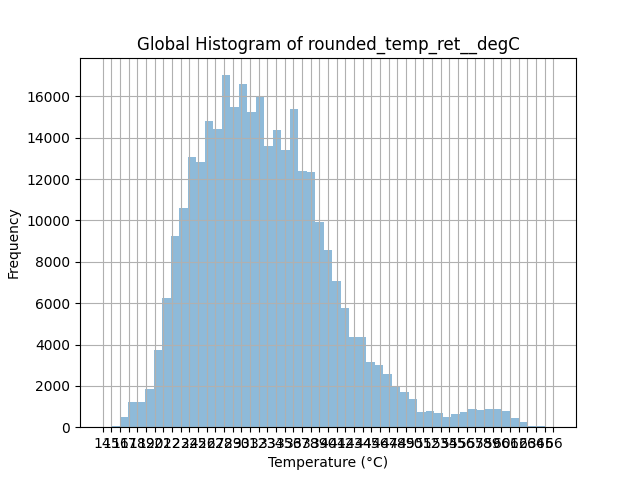

In [25]:
bins = int(df_returntemp['rounded_temp_ret__degC'].max()) + 1 - int(df_returntemp['rounded_temp_ret__degC'].min())
df_returntemp['rounded_temp_ret__degC'].to_frame().dropna(subset=['rounded_temp_ret__degC']).hist(bins=bins, alpha=0.5)  # Adjust `bins` to your preference
plt.xticks(range(int(df_returntemp['rounded_temp_ret__degC'].min()), 
                 int(df_returntemp['rounded_temp_ret__degC'].max()) + 1))
plt.title("Global Histogram of rounded_temp_ret__degC")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

In [26]:
len(df_returntemp[df_returntemp['rounded_temp_ret__degC'] < 30]) / len(df_returntemp)

0.38625108957920135

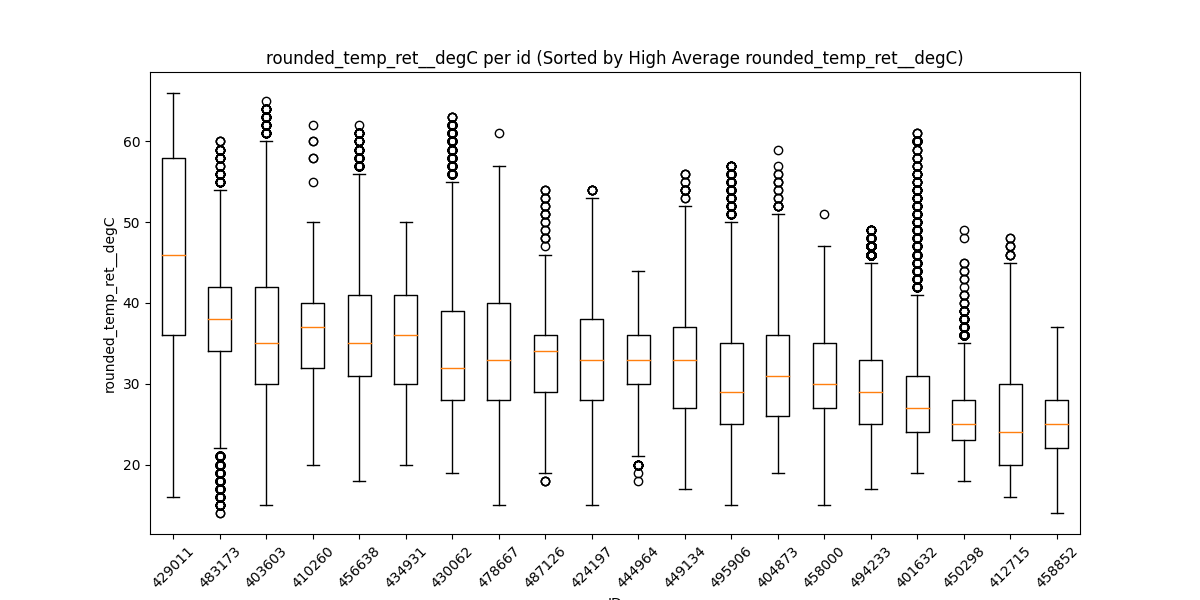

In [27]:
Plot.nfh_property_per_id_boxplot(df_prep, filter_col='batch_import_remeha_boiler_status_burning_ch__bool', property_col='rounded_temp_ret__degC')

In [28]:
df_prep.groupby(level='id').count().T

id,401632,403603,404873,410260,412715,424197,429011,430062,434931,444964,449134,450298,456638,458000,458852,478667,483173,487126,494233,495906
batch_import_KNMI_ghi__W_m_2,182401,181921,182401,182401,181981,181201,181381,181381,182461,181681,181681,181381,182221,181381,182401,181201,181801,181261,181741,181201
batch_import_KNMI_temp_out__degC,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821,182821
batch_import_remeha_temp_out__degC,0,0,0,0,0,0,0,0,0,0,0,0,0,117370,0,29440,0,0,0,0
batch_import_KNMI_wind__m_s_1,182821,182761,182731,182731,182701,182551,182821,182281,182821,182641,182641,182821,182821,182281,182731,182551,182731,182821,182641,182551
batch_import_enelogic_e_ret_monthly_hi_cum__kWh,527041,527041,527041,527041,0,527041,0,0,527041,527041,527041,527041,527041,527041,527041,527041,527041,527041,527041,527041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
device_p1-reader_e_use_lo__W,79824,84083,99865,72170,89725,41249,90835,75065,108239,103056,91592,108419,110618,102456,86559,110495,82750,83782,108035,79601
device_p1-reader_g_use_hhv__W,79825,83996,99900,72175,89725,41249,90891,75066,108239,103060,91589,108420,110620,102460,86425,110499,82769,83785,108019,79620
calculated_device_p1-reader_e_use__W,79824,84083,99865,72170,89725,41249,90835,75065,108239,103056,91592,108419,110618,102456,86559,110495,82750,83782,108035,79601
calculated_device_p1-reader_e_ret__W,267,84083,99865,72170,89725,41249,90835,75065,108239,103056,91592,108419,110618,102456,86559,534,82750,0,108035,79601


In [29]:
pd.concat([df_prep.dropna().groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_min__min_1'].unique(),
           df_prep.dropna().groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_max__min_1'].unique()],
          axis=1).sort_values(by='batch_import_remeha_ch_set_fan_rotations_max__min_1', ascending=True)

,batch_import_remeha_ch_set_fan_rotations_min__min_1,batch_import_remeha_ch_set_fan_rotations_max__min_1
id,,
458000,[1900],[4600]


In [30]:
df_prep.groupby(level='id')['batch_import_remeha_ch_set_fan_rotations_max__min_1'].unique()

id
401632    [<NA>, 4400]
403603    [<NA>, 5900]
404873    [<NA>, 4700]
410260    [<NA>, 3200]
412715    [<NA>, 4700]
424197    [<NA>, 4700]
429011    [<NA>, 7000]
430062    [<NA>, 4600]
434931    [<NA>, 4400]
444964    [<NA>, 4400]
449134    [<NA>, 2700]
450298    [<NA>, 4400]
456638    [<NA>, 4700]
458000    [<NA>, 4600]
458852    [<NA>, 4600]
478667    [<NA>, 4700]
483173          [<NA>]
487126    [<NA>, 4400]
494233    [<NA>, 4600]
495906    [<NA>, 5900]
Name: batch_import_remeha_ch_set_fan_rotations_max__min_1, dtype: object

In [31]:
# Merge df_prep with df_homes to get the brand_model for each id
df_prep = df_prep.reset_index().merge(df_homes, on='id').set_index(['id', 'timestamp'])

In [32]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9582620 entries, (401632, Timestamp('2023-04-01 00:00:00+0200', tz='Europe/Amsterdam')) to (495906, Timestamp('2024-04-04 01:00:00+0200', tz='Europe/Amsterdam'))
Data columns (total 95 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   batch_import_KNMI_ghi__W_m_2                             Float32
 1   batch_import_KNMI_temp_out__degC                         Float32
 2   batch_import_remeha_temp_out__degC                       Float32
 3   batch_import_KNMI_wind__m_s_1                            Float32
 4   batch_import_enelogic_e_ret_monthly_hi_cum__kWh          Float64
 5   batch_import_enelogic_e_ret_monthly_lo_cum__kWh          Float64
 6   batch_import_enelogic_e_use_monthly_hi_cum__kWh          Float64
 7   batch_import_enelogic_e_use_monthly_lo_cum__kWh          Float64
 8   batch_import_enelogic_g_use_monthly_cum__m3       

In [33]:
df_prep.batch_import_remeha_temp_in__degC.mean()

18.995998

In [34]:
df_prep.count()

batch_import_KNMI_ghi__W_m_2                       3635480
batch_import_KNMI_temp_out__degC                   3656420
batch_import_remeha_temp_out__degC                  146810
batch_import_KNMI_wind__m_s_1                      3653450
batch_import_enelogic_e_ret_monthly_hi_cum__kWh    8959697
                                                    ...   
100%_load_ch_rotations_min_1                       9582620
100%_load_ch__g25_3_ref_lhv__kW                    9582620
rotation__m3                                       9582620
power_ch_min__kW                                   9582620
power_ch_max__kW                                   9582620
Length: 95, dtype: int64

In [35]:
remeha2nfh = {
    'parHeFanRpmChMax': 'batch_import_remeha_ch_set_fan_rotations_max__min_1',
    'parHeFanRpmMin': 'batch_import_remeha_ch_set_fan_rotations_min__min_1',
    'parHePowerMax': 'power_ch_max__kW',
    'parHePowerMin': 'power_ch_min__kW',
    'parHeFanRpmMin.Minimum': 'min_fan_rotations__min_1',
    'parHeFanRpmChMax.Maximum': 'max_ch_fan_rotations__min_1',
    'varHeFanRpm': 'batch_import_remeha_fan_rotations__min_1',
    'varApPowerActual': 'batch_import_remeha_g_use_ch_and_dhw__kW0'
}


In [36]:
df_prep[df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == True][remeha2nfh['varHeFanRpm']].describe()

count    306124.0
mean      2162.31
std        645.14
min           0.0
25%        1890.0
50%        1950.0
75%        2100.0
max        7030.0
Name: batch_import_remeha_fan_rotations__min_1, dtype: Float64

In [37]:
%%time
# Create lookup value for boiler load fraction (how far along the current fan RPM is between the min and max)
df_prep.loc[:,'calculated_p_load__0'] = (df_prep[remeha2nfh['varHeFanRpm']] / df_prep[remeha2nfh['parHeFanRpmChMax.Maximum']]).astype('Float32')


CPU times: user 21.2 ms, sys: 408 µs, total: 21.6 ms
Wall time: 20.8 ms


In [38]:
df_prep[df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == True]['calculated_p_load__0'].describe()

count    306124.0
mean         0.29
std          0.08
min           0.0
25%          0.26
50%          0.28
75%          0.29
max          0.88
Name: calculated_p_load__0, dtype: Float64

In [58]:
%%time                                         

df_prep.loc[:,'calculated_g_use_ch__m3_s_1'] = df_prep['batch_import_remeha_fan_rotations__min_1']  * df_prep['rotation__m3'] / s_min_1

# initially, assume higher heating value of groningen gas
df_prep.loc[:,'gas_std_hhv__J_m_3'] = gas_groningen_nl_avg_std_hhv__J_m_3

# alternatively, use average of actual higher heating value
df_prep.loc[:,'gas_std_hhv__J_m_3'] = 35.974632 * 1e6

# # alternatively, use the actual higher heating value
# df_prep.loc[:,'gas_std_hhv__J_m_3'] = df_prep.loc['actual_gas_std_hhv__J_m_3']

# estimate of the higher heating value of 1 m3 of the gas input 
df_prep.loc[:,'gas_hhv__J_m_3'] = (df_prep['gas_std_hhv__J_m_3'] 
                                   * (df_prep['batch_import_KNMI_air__Pa'] + overpressure_gas_nl_avg__Pa)
                                   / (P_std__Pa + overpressure_gas_nl_avg__Pa)
                                   ) * (temp_gas_std__K / temp_gas_avg_nl__K)

df_prep.loc[:,'calculated_g_use_ch_hhv__W'] = df_prep['calculated_g_use_ch__m3_s_1'] * df_prep['gas_hhv__J_m_3']

KeyError: 'batch_import_KNMI_air__Pa'

In [40]:
%%time                                         

# calculate the gas input power
df_prep.loc[:,'calculated_g_use_ch_lhv__W'] = 1e3 * df_prep['100%_load_ch__g25_3_ref_lhv__kW'] * df_prep['calculated_p_load__0']

# Convert lower heating value of reference gas G25.3 used to Gronings gas, using higher heating value
df_prep.loc[:,'calculated_g_use_ch_hhv__W'] = df_prep['calculated_g_use_ch_lhv__W'] /  gas_g25_3_ref_lhv__J__m3 * gas_groningen_nl_avg_std_hhv__J_m_3

CPU times: user 87.5 ms, sys: 4.92 ms, total: 92.5 ms
Wall time: 28.4 ms


In [41]:
# Set the calculated gas use for central heating to zero when the boiler was not burning for central heating
df_prep.loc[df_prep['batch_import_remeha_boiler_status_burning_ch__bool'] == False, 'calculated_g_use_ch_lhv__W'] = 0

In [42]:
%%time
#Store rounded values for lookup in efficiency tables
df_prep.loc[:,'rounded_temp_ret__degC'] = df_prep['batch_import_remeha_temp_ret__degC'].round().astype('Int8')
df_prep.loc[:,'rounded_p_load__%'] = (df_prep['calculated_p_load__0'] * 100 ).round().astype('Int16')

CPU times: user 11.7 s, sys: 308 ms, total: 12.1 s
Wall time: 12 s


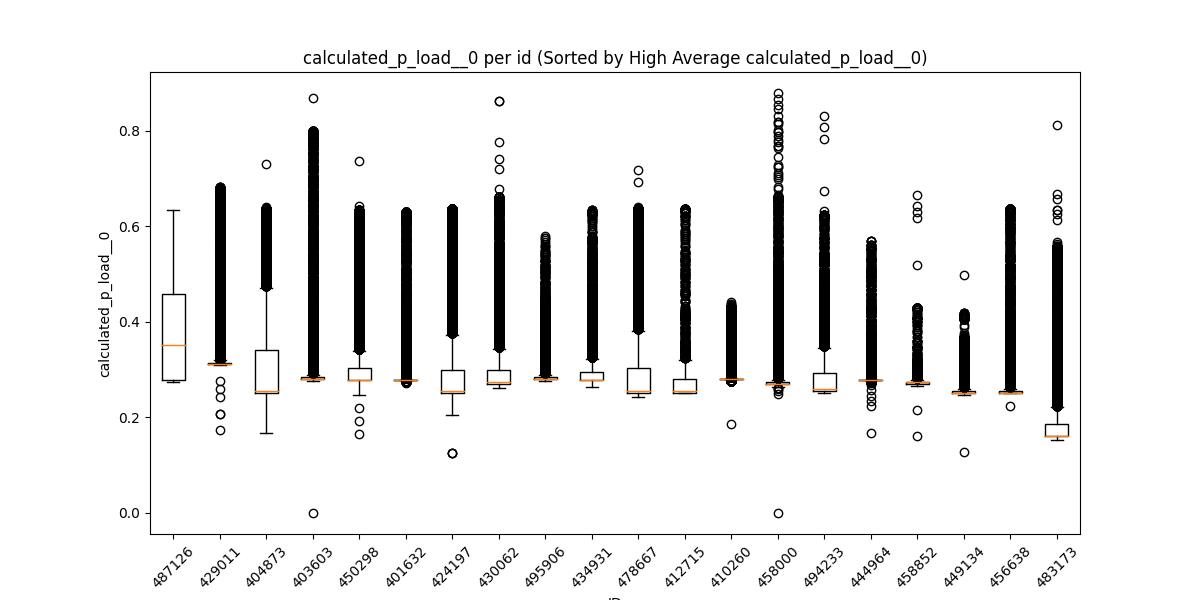

In [43]:
Plot.nfh_property_per_id_boxplot(df_prep, filter_col='batch_import_remeha_boiler_status_burning_ch__bool', property_col='calculated_p_load__0')

In [44]:
df_boiler_efficiency

eta_ch_hhv__W0
brand_model                 rounded_p_load__% rounded_temp_ret__degC                
Remeha Avanta Ace 28c       20.0              20.0                               1.0
                                              21.0                               1.0
                                              22.0                               1.0
                                              23.0                               1.0
                                              24.0                              0.99
...                                                                              ...
Remeha Tzerra Ace Matic 35c 100.0             66.0                              0.88
                                              67.0                              0.88
                                              68.0                              0.88
                                              69.0                              0.88
                                              70.0                              0.88

[33558 rows x 1 columns]

#### Actual lookup of momentary boiler efficiency from boiler-specific efficiency curves

In [45]:
%%time
# Merging DataFrames
df_prep = (df_prep
           .reset_index()
           .merge(df_boiler_efficiency.reset_index(),
                  on=['brand_model', 'rounded_p_load__%', 'rounded_temp_ret__degC'], 
                  how='left'
                  )
           .set_index(['id', 'timestamp'])
           .sort_index()
          )  


CPU times: user 10.4 s, sys: 2.77 s, total: 13.1 s
Wall time: 13.1 s


#### Calculating W_gain_ch__W based on boiler-specific efficiency

In [46]:
%%time
df_prep.loc[:,'calculated_Q_gain_ch__W'] = df_prep['calculated_g_use_ch_hhv__W'] * df_prep['eta_ch_hhv__W0']

CPU times: user 33.6 ms, sys: 0 ns, total: 33.6 ms
Wall time: 11.6 ms


In [47]:
list(df_prep.columns)

['batch_import_KNMI_ghi__W_m_2',
 'batch_import_KNMI_temp_out__degC',
 'batch_import_remeha_temp_out__degC',
 'batch_import_KNMI_wind__m_s_1',
 'batch_import_enelogic_e_ret_monthly_hi_cum__kWh',
 'batch_import_enelogic_e_ret_monthly_lo_cum__kWh',
 'batch_import_enelogic_e_use_monthly_hi_cum__kWh',
 'batch_import_enelogic_e_use_monthly_lo_cum__kWh',
 'batch_import_enelogic_g_use_monthly_cum__m3',
 'batch_import_remeha_boiler_status_blocking_mode__bool',
 'batch_import_remeha_boiler_status_burner_start__bool',
 'batch_import_remeha_boiler_status_burner_stop__bool',
 'batch_import_remeha_boiler_status_burning_ch__bool',
 'batch_import_remeha_boiler_status_burning_dhw__bool',
 'batch_import_remeha_boiler_status_controlled_stop__bool',
 'batch_import_remeha_boiler_status_de_air__bool',
 'batch_import_remeha_boiler_status_heat_demand__bool',
 'batch_import_remeha_boiler_status_locking_mode__bool',
 'batch_import_remeha_boiler_status_pump_post_run__bool',
 'batch_import_remeha_boiler_status_s

#### Inspect results

In [48]:
df_heat_dist = df_prep[['batch_import_KNMI_ghi__W_m_2',
                        'batch_import_KNMI_temp_out__degC',
                        'batch_import_KNMI_wind__m_s_1',
                        'device_p1-reader_g_use_hhv__W',
                        'batch_import_remeha_boiler_status_burning_ch__bool',
                        'batch_import_remeha_gas_valve_closed__bool',
                        'batch_import_remeha_gas_valve_open__bool',
                        'batch_import_remeha_fan_rotations__min_1', 
                        'batch_import_remeha_ch_set_fan_rotations_min__min_1', 
                        'batch_import_remeha_ch_set_fan_rotations_max__min_1', 
                        'boiler_default_min_fan_rotations__min_1', 
                        'boiler_default_max_ch_fan_rotations__min_1', 
                        'batch_import_remeha_g_use_ch_lhv__W',
                        'batch_import_remeha_temp_set__degC',
                        'batch_import_remeha_temp_in__degC',
                        'device_living_room_calibrated_temp_in__degC',
                        'batch_import_remeha_temp_sup__degC',
                        'batch_import_remeha_temp_ret__degC',
                        'batch_import_remeha_temp_ch_sup_max__degC', 
                        'calculated_p_load__0',
                        'calculated_g_use_ch_hhv__W',
                        'eta_ch_hhv__W0',
                        'calculated_Q_gain_ch__W',
                        'rounded_p_load__%',
                        'rounded_temp_ret__degC',
                       ]]

In [49]:
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True].groupby(level='id').agg({
    'batch_import_remeha_fan_rotations__min_1': ['min', 'mean', 'max'],
    'batch_import_remeha_g_use_ch_lhv__W': ['min', 'mean', 'max'],
    'calculated_p_load__0': ['min', 'mean', 'max'],
    'calculated_g_use_ch_hhv__W': ['min', 'mean', 'max'],
    'calculated_Q_gain_ch__W': ['min', 'mean', 'max'],
}).T

id                                               401632    403603    404873  \
batch_import_remeha_fan_rotations__min_1 min       1902         0      1240   
                                         mean    2119.3   2365.59   2377.95   
                                         max       4410      6420      5400   
batch_import_remeha_g_use_ch_lhv__W      min        0.0       0.0       0.0   
                                         mean    4508.8   2981.38   4583.13   
                                         max    60000.0   60000.0   60000.0   
calculated_p_load__0                     min       0.27       0.0      0.17   
                                         mean       0.3      0.32      0.32   
                                         max       0.63      0.87      0.73   
calculated_g_use_ch_hhv__W               min   11114.82       0.0   4727.29   
                                         mean  12384.68  13114.28   9065.51   
                                         max   25770.96  35590.94  20586.57   
calculated_Q_gain_ch__W                  min    9945.84   9843.59   6022.26   
                                         mean  12057.88  12466.02   8805.17   
                                         max    24719.5  33217.03  19446.08   

id                                               410260    412715    424197  \
batch_import_remeha_fan_rotations__min_1 min       1380      1860       930   
                                         mean   2141.89   2192.54   2229.12   
                                         max       3270      4710      4710   
batch_import_remeha_g_use_ch_lhv__W      min        0.0       0.0       0.0   
                                         mean       0.0   2605.26   6835.77   
                                         max        0.0   60000.0   60000.0   
calculated_p_load__0                     min       0.19      0.25      0.13   
                                         mean      0.29       0.3       0.3   
                                         max       0.44      0.64      0.64   
calculated_g_use_ch_hhv__W               min    7650.39   7090.93   3545.47   
                                         mean  11874.15   8358.68   8498.12   
                                         max    18128.1  17956.07  17956.07   
calculated_Q_gain_ch__W                  min    9870.73   6461.97   6024.16   
                                         mean  11375.94   8393.81   8236.53   
                                         max   17792.94  17417.38  17508.96   

id                                               429011    430062    434931  \
batch_import_remeha_fan_rotations__min_1 min       1783      1830      1849   
                                         mean   3459.17    2105.1   2090.96   
                                         max       7030      6030      4440   
batch_import_remeha_g_use_ch_lhv__W      min        0.0       0.0       0.0   
                                         mean   7314.92    996.37   4527.91   
                                         max    60000.0   60000.0   60000.0   
calculated_p_load__0                     min       0.17      0.26      0.26   
                                         mean      0.34       0.3       0.3   
                                         max       0.68      0.86      0.63   
calculated_g_use_ch_hhv__W               min    6287.58   7682.52   10805.1   
                                         mean  12198.44   8837.42  12219.06   
                                         max   24790.62  25314.54  25946.27   
calculated_Q_gain_ch__W                  min    6598.66   6666.89  10149.62   
                                         mean  11228.35   8436.12  11652.21   
                                         max   23983.43   23798.2  24791.66   

id                                               444964    449134    450298  \
batch_import_remeha_fan_rotations__min_1 min       1170       945      1152   
                                         mean  

In [50]:
df_heat_dist.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9582620 entries, (401632, Timestamp('2023-04-01 00:00:00+0200', tz='Europe/Amsterdam')) to (495906, Timestamp('2024-04-04 01:00:00+0200', tz='Europe/Amsterdam'))
Data columns (total 25 columns):
 #   Column                                               Dtype  
---  ------                                               -----  
 0   batch_import_KNMI_ghi__W_m_2                         Float32
 1   batch_import_KNMI_temp_out__degC                     Float32
 2   batch_import_KNMI_wind__m_s_1                        Float32
 3   device_p1-reader_g_use_hhv__W                        Float64
 4   batch_import_remeha_boiler_status_burning_ch__bool   boolean
 5   batch_import_remeha_gas_valve_closed__bool           boolean
 6   batch_import_remeha_gas_valve_open__bool             boolean
 7   batch_import_remeha_fan_rotations__min_1             Int16  
 8   batch_import_remeha_ch_set_fan_rotations_min__min_1  Int16  
 9   batch_import_remeha_ch_s

In [51]:
# Group by 'id' and calculate the mean for both 'eta_ch_hhv__W0' and 'batch_import_remeha_temp_ret__degC'
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True].groupby(level='id').agg({
    'eta_ch_hhv__W0': 'mean',
    'batch_import_remeha_temp_ret__degC': 'mean',
    'batch_import_remeha_temp_ch_sup_max__degC': 'mean',
    'batch_import_remeha_temp_sup__degC': 'mean'
}).sort_values(by='eta_ch_hhv__W0', ascending=False)

,eta_ch_hhv__W0,batch_import_remeha_temp_ret__degC,batch_import_remeha_temp_ch_sup_max__degC,batch_import_remeha_temp_sup__degC
id,,,,
412715,0.99,25.57,80.0,36.45
450298,0.98,25.65,55.0,37.56
458852,0.98,24.89,80.0,46.53
494233,0.98,29.91,60.0,37.86
401632,0.98,28.2,80.0,40.78
404873,0.98,30.96,80.0,41.73
449134,0.97,32.47,80.0,46.56
495906,0.97,30.99,80.0,52.53
424197,0.97,32.79,80.0,43.86


In [52]:
df_heat_dist[df_heat_dist['batch_import_remeha_boiler_status_burning_ch__bool'] == True]['eta_ch_hhv__W0'].mean() 

0.9664982438383352

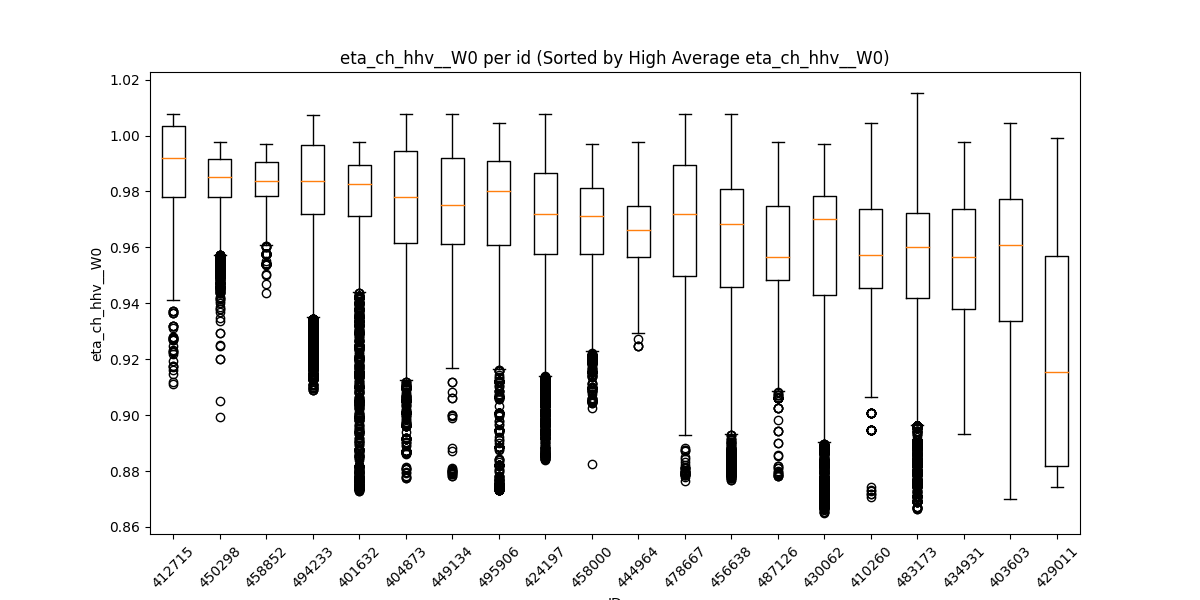

In [53]:
Plot.nfh_property_per_id_boxplot(df_heat_dist, filter_col='batch_import_remeha_boiler_status_burning_ch__bool', property_col='eta_ch_hhv__W0')

## Learn energy profile parameters

Most of the heavy lifting is done by the `learn_energy_profile()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [54]:
# set room metadata to None, then learn_home_parameters() will derive the metadata from the ids.

hints = {
    'A_sol__m2': A_sol_nl_avg__m2,                      # initial estimate for apparent solar aperture
    'eta_ch_hhv__W0' : eta_ch_nl_avg_hhv__W0,           # average home heating efficiency of a gas boiler (based on higher heating value)
    'eta_not_ch_hhv__W0' : eta_not_ch_nl_avg_hhv__W0,   # average home heating efficiency indirecly DHW & cooking (based on higher heating value value)  
    'g_not_ch_hhv__W' : g_not_ch_nl_avg_hhv__W,         # average gas power (heating value) for other purposes than home heating [W] 
    'occupancy__p' : occupancy_nl_avg__p,               # average house occupancy (1.5: 2.2 persons, at home for 16.3 of 24 hours)
    'Q_gain_int__W_p_1' : Q_gain_int_nl_avg__W_p_1,     # average heat gain per occupant (77 W for 8.6 hours, 105 W for 7.7 hours)
    'wind_chill__K_s_m_1' : wind_chill_nl_avg__K_s_m_1, # average for Dutch homes, according to KNMI: https://cdn.knmi.nl/knmi/pdf/bibliotheek/knmipubmetnummer/knmipub219.pdf 
    'A_inf__m2': A_inf_nl_avg__m2,                       # average effective infiltration area corresponding to wind_chill_nl_avg__K_s_m_1
    'H_nl_avg__W_K_1' : H_nl_avg__W_K_1                 # average specific heat loss for a Dutch home
}

learn = ['A_sol__m2']

#define and select column names
property_sources = {
    'temp_in__degC' : 'batch_import_remeha_temp_in__degC',
    'temp_out__degC' : 'batch_import_KNMI_temp_out__degC',
    'wind__m_s_1' : 'batch_import_KNMI_wind__m_s_1',
    'ghi__W_m_2' : 'batch_import_KNMI_ghi__W_m_2', 
    'g_use_hhv__W' : 'device_p1-reader_g_use_hhv__W',
    'e_use__W' : 'calculated_device_p1-reader_e_use__W',
    'e_ret__W' : 'calculated_device_p1-reader_e_ret__W',
    'occupancy__p': 'device_living_room_occupancy__p' 
}

In [55]:
# learn the model parameters and write results to a dataframe
%autoreload 2
df_results_per_period, df_results = Learner.learn_energy_profile(df_prep, 
                                                                  property_sources = property_sources, 
                                                                  learn = learn, 
                                                                  hints = hints,
                                                                  ev_type = 2
                                                                 )

  0%|          | 0/20 [00:00<?, ?it/s]

/home/jovyan/needforheat-analysis/examples/../analysis/rhc_analysis.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scaling_factor =  (avg_g_use__W - g_not_ch_hhv__W) / uncorrected_g_use_ch_hhv_W


TypeError: must be real number, not NAType

### Result per learning period

In [ ]:
df_results_per_period

In [ ]:
# show essential statistics for the learned values
df_stats = df_results_per_period.describe().filter(regex='^actual_|^learned_')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

In [ ]:
# show essential statistics for the errors
df_stats = df_results_per_period.describe().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

In [ ]:
# show essential statistics for the error values, per id
df_stats = df_results_per_period.groupby('id').describe().stack().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(1).isin(['mean', 'std', 'min', 'max'])]

### Result Visualization

In [ ]:
df_results

In [ ]:
df_plot = df_prep[[prop for prop in df_prep.columns.values if prop.split('__')[-1] == 'degC']]

In [ ]:
#Plot only temperatures from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)

In [ ]:
df_lot = df_prep

In [ ]:
#Plot all properties from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)